# LSTM Lunch and Learn

# Intro/Goal

## Your current understanding of RNNs:

![](img/LSTM_next_character.png)

# RNN Basics

## Reminder

![](img/rnn_unrolling.png)

#### "RNNs have a hidden state that feeds back into the cell at the next time step"

## What is actually going on?

### Example with sequence length 5

![](img/rnn_forward.png)

### What about the backwards pass?

![](img/rnn_backward.png)

## Illustration

![](img/rnn_in_detail.png)

## What about deep learning?

### What would an RNN with multiple layers look like?

![](img/rnn_forward_1.png)

### Or, equivalently...

![](img/rnn_forward_2.png)

## What about the backward pass?

![](img/rnn_backward_1.png)

### Or equivalently...

![](img/rnn_backward_2.png)

# What about LSTMs?

### LSTM Cells:

![](img/lstm_olah.png)

## Data Flowing Forward Through an LSTM-based Network

![](img/lstm_forward_1.png)

### Or equivalently

![](img/lstm_forward_2.png)

## Data Flowing Backward Through an LSTM-based Network

![](img/lstm_backward_1.png)

### Or equivalently:

![](img/lstm_backward_2.png)

# Let's code it up

Note: I used [this minimal example](https://gist.github.com/karpathy/d4dee566867f8291f086) from Andrej Karpathy as a starting point.

## Imports

In [1]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
%matplotlib inline

from copy import deepcopy
from collections import deque

## Activations

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))


def row_softmax(input_array):    
    a_exp = np.exp(input_array)
    row_sums = a_exp.sum(axis=1)
    new_matrix = a_exp / row_sums[:, np.newaxis]
    return new_matrix

## `LSTM_Param` class

In [3]:
class LSTM_Param:
    '''
    A class that holds weight matrices along with their derivatives and momentum.
    '''
    def __init__(self, value):
        '''
        param value: numpy array, two dimensional, shape of the weight matrix
        '''
        self.value = value
        self.deriv = np.zeros_like(value) #derivative
        self.momentum = np.zeros_like(value) #momentum for AdaGrad
        
    def clear_gradient(self):
        '''
        Resets the value of the derivative
        '''
        self.deriv = np.zeros_like(self.value) #derivative
        
    def clip_gradient(self):
        '''
        Clips the derivative, setting its min value to -1 and its max value to 1.
        '''
        self.deriv = np.clip(self.deriv, -2, 2, out=self.deriv)
        
    def update(self, learning_rate):
        '''
        Update parameter values according to AdaGrad rules.
        param learning_rate: float - the learning rate
        '''
        self.momentum += self.deriv * self.deriv # Calculate sum of gradients
        self.value += -(learning_rate * self.deriv / np.sqrt(self.momentum + 1e-8))
        
    def update_sgd(self, learning_rate):
        '''
        Update parameter values according to stochastic gradient descent rules.
        param learning_rate: float - the learning rate
        '''
        self.value -= learning_rate * self.deriv

## `LSTM_Params` class

In [4]:
class LSTM_Params:
    
    def __init__(self, hidden_size, vocab_size):
        '''
        The parameters to be used when updating the values in an LSTM_Layer, which is a layer
        of LSTM cells stretched out over time.
        param hidden_size: int - the number of "hidden neurons" in the layer. This can be 
        different for each layer.
        param vocab_size: int - the number of characters in the vocabulary that we are predicting
        the next character of.
        Note: the shape of these weight matrices assumes that the data will be fed in as "rows", 
        meaning that each data point will be represented by a numpy array of shape (1, vocab_size)
        '''
        self.stack_size = hidden_size + vocab_size
        
        self.W_f = LSTM_Param(np.random.normal(size=(self.stack_size, hidden_size), loc=0, scale=0.1))
        self.W_i = LSTM_Param(np.random.normal(size=(self.stack_size, hidden_size), loc=0, scale=0.1))
        self.W_c = LSTM_Param(np.random.normal(size=(self.stack_size, hidden_size), loc=0, scale=0.1))
        self.W_o = LSTM_Param(np.random.normal(size=(self.stack_size, hidden_size), loc=0, scale=0.1))
        self.W_v = LSTM_Param(np.random.normal(size=(hidden_size, vocab_size), loc=0, scale=0.1))
        
        '''
        Biases always have the dimensions of the output of the transformation that they are being added to.
        '''
        self.B_f = LSTM_Param(np.zeros((1, hidden_size)))
        self.B_i = LSTM_Param(np.zeros((1, hidden_size)))
        self.B_c = LSTM_Param(np.zeros((1, hidden_size)))
        self.B_o = LSTM_Param(np.zeros((1, hidden_size)))
        self.B_v = LSTM_Param(np.zeros((1, vocab_size)))

        
    def all_params(self):
        '''
        Returns a list of all the parameters for easy iteration
        '''
        return [self.W_f, self.W_i, self.W_c, self.W_o, self.W_v, 
                self.B_f, self.B_i, self.B_c, self.B_o, self.B_v]
        
    def clear_gradients(self):
        '''
        Clears all the gradients
        '''
        for param in self.all_params():
            param.clear_gradient()
        
    def clip_gradients(self):
        '''
        Clips all the gradients
        '''
        for param in self.all_params():
            param.clip_gradient()       
       
    def update_params(self, learning_rate, method="ada"):
        '''
        Updates all the parameters according to the "AdaGrad" rule.
        '''
        for param in self.all_params():
            if method == "ada":
                param.update(learning_rate)  
            elif method == "sgd":
                param.update_sgd(learning_rate)

## `LSTM_Node`

In [5]:
class LSTM_Node:
    '''
    An LSTM Node performing the role of the "circles" in the diagrams above.
    It takes has two methods:
    1. "forward" which takes in: 
        * An observation, "X"
        * A hidden state from the prior time step, "H_prev"
        * A cell state from the prior time step, "C_prev"
        And returns:
        * The output "X_out" to be passed on to the next layer.
        * The output "H" to be passed into the next node as the hidden state
        * The output "C" to be passed into the next node as the cell state
    2. "backward" which takes in: 
        * The gradient of the output with respect to the loss, "out_grad"
        * The gradient of the hidden state with respect to the loss, "h_grad"
        * The gradient of the cell state with respect to the loss, "c_grad"
        And returns:
        * The gradient of the output of the same time step in the prior layer - the circle "below" in the 
        drawings above - "dx_grad"
        * The gradient of the hidden state from the prior time step, "dh_grad" 
        * The gradient of the cell state from the prior time step, "dc_grad" 
    
    It uses as parameters, not its own parameters, but the parameters from the LSTM_Layer that it is a part of.
        '''
    def __init__(self, hidden_size, vocab_size):
        '''
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        '''
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

    def forward(self, x, H_prev, C_prev, LSTM_Params):
        '''
        param x: numpy array of shape (1, vocab_size)
        param H_prev: numpy array of shape (1, hidden_size)
        param C_prev: numpy array of shape (1, hidden_size)
        return self.x_out: numpy array of shape (1, vocab_size)
        return self.H: numpy array of shape (1, hidden_size)
        return self.C: numpy array of shape (1, hidden_size)
        '''
        self.C_prev = C_prev

        self.z = np.column_stack((x, H_prev))
        
        self.f = sigmoid(np.dot(self.z, LSTM_Params.W_f.value) + LSTM_Params.B_f.value)
        self.i = sigmoid(np.dot(self.z, LSTM_Params.W_i.value) + LSTM_Params.B_i.value)
        self.C_bar = tanh(np.dot(self.z, LSTM_Params.W_c.value) + LSTM_Params.B_c.value)

        self.C = self.f * C_prev + self.i * self.C_bar
        self.o = sigmoid(np.dot(self.z, LSTM_Params.W_o.value) + LSTM_Params.B_o.value)
        self.H = self.o * tanh(self.C)

        self.x_out = np.dot(self.H, LSTM_Params.W_v.value) + LSTM_Params.B_v.value
        
        return self.x_out, self.H, self.C 


    def backward(self, loss_grad, dh_next, dC_next, LSTM_Params):
        '''
        param loss_grad: numpy array of shape (1, vocab_size)
        param dh_next: numpy array of shape (1, hidden_size)
        param dC_next: numpy array of shape (1, hidden_size)
        param LSTM_Params: LSTM_Params object
        return self.dx_prev: numpy array of shape (1, vocab_size)
        return self.dH_prev: numpy array of shape (1, hidden_size)
        return self.dC_prev: numpy array of shape (1, hidden_size)
        '''
        LSTM_Params.W_v.deriv += np.dot(self.H.T, loss_grad)
        LSTM_Params.B_v.deriv += loss_grad

        dh = np.dot(loss_grad, LSTM_Params.W_v.value.T)        
        dh += dh_next
        do = dh * tanh(self.C)
        do_int = dsigmoid(self.o) * do
        LSTM_Params.W_o.deriv += np.dot(self.z.T, do_int)
        LSTM_Params.B_o.deriv += do_int

        dC = np.copy(dC_next)
        dC += dh * self.o * dtanh(tanh(self.C))
        dC_bar = dC * self.i
        dC_bar_int = dtanh(self.C_bar) * dC_bar
        LSTM_Params.W_c.deriv += np.dot(self.z.T, dC_bar_int)
        LSTM_Params.B_c.deriv += dC_bar_int

        di = dC * self.C_bar
        di_int = dsigmoid(self.i) * di
        LSTM_Params.W_i.deriv += np.dot(self.z.T, di_int)
        LSTM_Params.B_i.deriv += di_int

        df = dC * self.C_prev
        df_int = dsigmoid(self.f) * df
        LSTM_Params.W_f.deriv += np.dot(self.z.T, df_int)
        LSTM_Params.B_f.deriv += df_int

        dz = (np.dot(df_int, LSTM_Params.W_f.value.T)
             + np.dot(di_int, LSTM_Params.W_i.value.T)
             + np.dot(dC_bar_int, LSTM_Params.W_c.value.T)
             + np.dot(do_int, LSTM_Params.W_o.value.T))
        dx_prev = dz[:, :self.vocab_size]
        dH_prev = dz[:, self.vocab_size:]
        dC_prev = self.f * dC
        
        return dx_prev, dH_prev, dC_prev

## `LSTM_Layer` class

In [6]:
class LSTM_Layer:
    '''
    Corresponds to a "row" of circles in the diagrams above. 
    We initialize a layer with a number of "Nodes" equal to the length of the sequences we passin.
    Again, the key methods are "forward" and "backward".
    1. "forward":
        * Passes data forward through all the nodes in the layer
        * Sets the hidden and cell states outputted by the last node to be those that will be passed in when the
        next sequence is fed through the layer
        * Passes the appropriate data on to the next layer in the network
    2. "backward":
        * Passes gradient backward through all the nodes in the layer
        * Sets the hidden state outputted by the last node equal to the node 
        * Passes the appropriate gradient on to the previous layer in the network
    '''
    def __init__(self, sequence_length, vocab_size, hidden_size, learning_rate):
        '''
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param learning_rate: float - the learning rate
        '''
        self.nodes = [LSTM_Node(hidden_size, vocab_size) for x in range(sequence_length)]
        self.sequence_length = sequence_length
        self.start_H = np.zeros((1, hidden_size))
        self.start_C = np.zeros((1, hidden_size))
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.params = LSTM_Params(hidden_size, vocab_size)

    
    def forward(self, x_seq_in):
        '''
        param x_seq_in: numpy array of shape (sequence_length, vocab_size)
        return x_seq_out: numpy array of shape (sequence_length, vocab_size)
        '''
        H_in = np.copy(self.start_H)
        C_in = np.copy(self.start_C)
        
        num_chars = x_seq_in.shape[0]
        
        x_seq_out = np.zeros((num_chars, self.vocab_size))
        
        for t in range(num_chars):

            # Need to cast this one dimensional numpy array to two dimensions
            # for the matrix multiplication to work
            x_in = np.array(x_seq_in[t, :], ndmin=2)
            
            y_out, H_in, C_in = self.nodes[t].forward(x_in, H_in, C_in, self.params)
      
            x_seq_out[t, :] = y_out
    
        self.start_H = H_in
        self.start_C = C_in

        return x_seq_out


    def backward(self, loss_grad):
        '''
        param loss_grad: numpy array of shape (sequence_length, vocab_size)
        return loss_grad_out: numpy array of shape (sequence_length, vocab_size)
        '''
        dh_next = np.zeros_like(self.start_H) #dh from the next character
        dC_next = np.zeros_like(self.start_C) #dc from the next character
        
        num_chars = loss_grad.shape[0]
        
        loss_grad_out = np.zeros((num_chars, self.vocab_size))
        
        for t in reversed(range(num_chars)):
            
            # Need to cast this one dimensional numpy array to two dimensions
            # for the matrix multiplication to work
            loss_grad_in = np.array(loss_grad[t, :], ndmin=2)

            grad_out, dh_next, dC_next = \
                self.nodes[t].backward(loss_grad_in, dh_next, dC_next, self.params)
        
            loss_grad_out[t, :] = grad_out
        
        return loss_grad_out

## `LSTM_Model` class

In [7]:
class LSTM_Model:
    '''
    The Model class that takes in inputs and targets and actually trains the network and calculates the loss.
    '''
    def __init__(self, num_layers, sequence_length, vocab_size, hidden_size, learning_rate):
        '''
        param num_layers: int - the number of layers in the network
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the each layer of the network.
        '''
        self.layers = [LSTM_Layer(sequence_length, vocab_size, hidden_size, learning_rate) for i in range(num_layers)]
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.learning_rate = learning_rate

        
    def forward(self, x_batch):
        '''
        param inputs: list of integers - a list of indices of characters being passed in as the 
        input sequence of the network.
        returns x_batch_in: numpy array of shape (sequence_length, vocab_size)
        '''       
        
        for layer in self.layers:

            x_batch = layer.forward(x_batch)
                
        return x_batch

    def _generate_one_hot_array(self, sequence):
        '''
        param sequence - sequence of indices of characters of length sequence_length.
        return batch - numpy array of shape (sequence_length, vocab_size)
        '''       
        sequence_length = len(sequence)
        batch = np.zeros((sequence_length, self.vocab_size))
        for i in range(sequence_length):
            batch[i, sequence[i]] = 1.0
        
        return batch
        
    def loss(self, x_batch_out, y_batch):
        '''
        param x_batch_out: numpy array with shape (sequence_length, vocab_size)
        returns loss: float, representing mean squared error loss
        '''
        loss = np.sum((x_batch_out - y_batch) ** 2)

        return loss
    
    
    def loss_gradient(self, x_batch_out, y_batch):
        '''
        param x_batch_out: numpy array with shape (sequence_length, vocab_size)
        returns loss: float, representing mean squared error loss
        '''

        return -1.0 * (y_batch - x_batch_out)

    def backward(self, loss_grad):
        '''
        param loss_grad: numpy array with shape (sequence_length, vocab_size)
        returns loss: float, representing mean squared error loss
        '''
        
        for layer in reversed(self.layers):

            loss_grad = layer.backward(loss_grad)
            
        return loss_grad
                
    def single_step(self, inputs, targets):
        '''
        The step that does it all:
        1. Forward pass & softmax
        2. Compute loss and loss gradient
        3. Backward pass
        4. Update parameters
        param inputs: array of length sequence_length that represents the character indices of the inputs to
        the network
        param targets: array of length sequence_length that represents the character indices of the targets
        of the network 
        return loss
        '''  
        
        x_batch_in = self._generate_one_hot_array(inputs)
        
        x_batch_out = self.forward(x_batch_in)
        
        x_softmax = row_softmax(x_batch_out)
        
        y_batch = self._generate_one_hot_array(targets)
        
        loss = self.loss(x_softmax, y_batch)
        
        loss_grad = self.loss_gradient(x_softmax, y_batch)
        
        for layer in self.layers:
            layer.params.clear_gradients()
        
        self.backward(loss_grad)

        for layer in self.layers:
            layer.params.clip_gradients()  
            layer.params.update_params(layer.learning_rate)
            
        
        return loss

## `Character_generator` class

In [8]:
class Character_generator:
    '''
    Takes in a text file and a model, and starts generating characters.
    '''
    def __init__(self, text_file, LSTM_Model):
        '''
        param text_file: path to text file containing characters that we are going to generate text to mimic
        param LSTM_Model: the LSTM_Model that we are using to generate the text 
        '''
        self.data = open(text_file, 'r').read()
        self.model = LSTM_Model
        self.chars = list(set(self.data))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch:i for i,ch in enumerate(self.chars)}
        self.idx_to_char = {i:ch for i,ch in enumerate(self.chars)}
        self.sequence_length = self.model.sequence_length
    
    def _generate_inputs_targets(self, start_pos):
        '''
        Given a start position, generates a list of inputs and targets.
        param start_pos: int - index of start position in characters 
        return inputs: list - list of length sequence_length with the indices of the characters forming the 
        inputs to the model 
        return targets: list - list of length sequence_length with the indices of the characters forming the 
        targets of the model
        '''
        inputs = ([self.char_to_idx[ch] 
                   for ch in self.data[start_pos: start_pos + self.sequence_length]])
        targets = ([self.char_to_idx[ch] 
                    for ch in self.data[start_pos + 1: start_pos + self.sequence_length + 1]])
        return inputs, targets


    def sample_output(self, input_char, sample_length):
        '''
        Generates a sample output using the current trained model.
        param input_char: int - index of the character to use to start generating a sequence
        param sample_length: int - the length of the sample output to generate
        return txt: string - a string of length sample_length representing the sample output
        '''
        indices = []
        
        sample_model = deepcopy(self.model)
        
        for i in range(sample_length):
            x_batch_in = self.model._generate_one_hot_array([input_char])
            
            x_batch_out = sample_model.forward(x_batch_in)
        
            x_softmax = row_softmax(x_batch_out)
        
            input_char = np.random.choice(range(self.vocab_size), p=x_softmax.ravel())
            
            indices.append(input_char)
            
        txt = ''.join(self.idx_to_char[idx] for idx in indices)
        return txt


    

    def train(self, num_iterations, sample_every=100):
        '''
        Trains the "character generator" for a number of iterations. 
        Each "iteration" feeds a batch size of 1 through the neural network.
        Continues until num_iterations is reached. Displays sample text generated using the latest version.
        '''
        plot_iter = np.zeros((0))
        plot_loss = np.zeros((0))
        
        num_iter = 0
        start_pos = 0
        
        moving_average = deque(maxlen=100)
        while num_iter < num_iterations:
            
            if start_pos + self.sequence_length > len(self.data):
                start_pos = 0
            
            ## Update the model
            inputs, targets = self._generate_inputs_targets(start_pos)
            loss = self.model.single_step(inputs, targets)

            moving_average.append(loss)
            ma_loss = np.mean(moving_average)
            
            start_pos += self.sequence_length
            
            plot_iter = np.append(plot_iter, [num_iter])
            plot_loss = np.append(plot_loss, [ma_loss])
            
            if num_iter % 100 == 0:
                plt.plot(plot_iter, plot_loss)
                display.clear_output(wait=True)
                plt.show()
                
                sample_text = self.sample_output(self.char_to_idx[self.data[start_pos]], 
                                                 200)
                print(sample_text)

            num_iter += 1
            
            

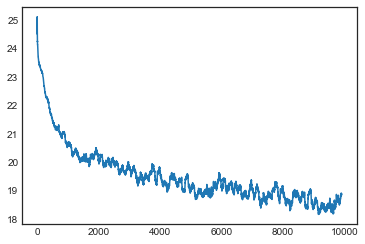

 fommy so'll.

KUCKeIAL:
N aawis s Ioke hinc' simk outung jazitcertilo, in, tallsnot mony oins hir on the wimyt.

KAnG CAL:
Thoush oud mave
corly aperele thea comind youldesb grecurpt
Teecemsir toub? 


In [9]:
mod = LSTM_Model(vocab_size=62, hidden_size=256, learning_rate=0.01, sequence_length=25, num_layers=1)
character_generator = Character_generator('input.txt', mod)
character_generator.train(10000, sample_every=100)